**Using Named Entity Recognition techniques to extract attributes from E-Commerce products data**

Students:
Maxim Segal, id: 317026557
Ron Levi, id: 200541456


**Goal**

We want to address a problem that is very important and prevalent in different domains of eCommerce: extracting products' attributes and their values from plain textual data.


**Motivation**

Quality extraction of products' attributes and having them saved in a structured manner can significantly improve search results in eCommerce retail system, enrich products catalog and improve the overall customer experience. 

Any eCommerce player, big as small, seeks to accurately predict and answer the customers' demand for products. This may lead to ways of enriching the offered catalogs.

Also, in the today's competitive world between eccomerce players, by precisely satisfying the demand for goods to the customers - the overall well-being of the economy increases.

Subsequently, we would like to address the above by building a tool that merges several existing state-of-the-art approaches in the field of Named Entity Recognition and tailor a solution for this specific task. 

In the above image we can see that customer query is not met appropriatly. We searched for a white iphone 7 but the results show that the phone model was not recognized from user's query. We aim to recognize the model of the product (in this case- 7) which will assist with search results optimization. 

**Proposed Solutions**

We want to try achieving viable, quality solution to product attributes extraction: 

given a plain text descriptions and/or other (unstructured) specifications we aim to extract the needed data in (attribute:value) pairs. As said, it can be utilized for search optimization and also helping decision makers to attain a better understanding of their catalog and make informed buisness decisions. Our pipeline will be as follows:
![picture](https://www.nltk.org/images/ie-architecture.png)

**Datasets**

Initially, for the purpose of this POC and due to products dataset currently unavailable, we will demonstrate several NER approaches in conceptually similar tasks. We will use alternative datasets just to present these techniques. The datasets are:
- **CoNLL 2002**:
Spanish annotated dataset from NLTK for extracting person/organization/location/misc named entities from spanish corpora. This dataset is composed of list of sentences where each sentence is structured in the standard representation scheme of IOB tags, a tuple in following order: (the token, its Part Of Speach tag, its entity label).
Lets see how the annotated sentences data actually look like:


In [7]:
import nltk
nltk.download('conll2002') # dataset

train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
print('This is an example of an annotated sentence: \n')
train_sents[5]


[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\segal\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


This is an example of an annotated sentence: 



[('Por', 'SP', 'O'),
 ('su', 'DP', 'O'),
 ('parte', 'NC', 'O'),
 (',', 'Fc', 'O'),
 ('el', 'DA', 'O'),
 ('Abogado', 'NC', 'B-PER'),
 ('General', 'AQ', 'I-PER'),
 ('de', 'SP', 'O'),
 ('Victoria', 'NC', 'B-LOC'),
 (',', 'Fc', 'O'),
 ('Rob', 'NC', 'B-PER'),
 ('Hulls', 'AQ', 'I-PER'),
 (',', 'Fc', 'O'),
 ('indicó', 'VMI', 'O'),
 ('que', 'CS', 'O'),
 ('no', 'RN', 'O'),
 ('hay', 'VAI', 'O'),
 ('nadie', 'PI', 'O'),
 ('que', 'PR', 'O'),
 ('controle', 'VMS', 'O'),
 ('que', 'CS', 'O'),
 ('las', 'DA', 'O'),
 ('informaciones', 'NC', 'O'),
 ('contenidas', 'AQ', 'O'),
 ('en', 'SP', 'O'),
 ('CrimeNet', 'NC', 'B-MISC'),
 ('son', 'VSI', 'O'),
 ('veraces', 'AQ', 'O'),
 ('.', 'Fp', 'O')]

- **CoNLL 2003**: 

The CoNLL-2003 is an English named entity dataset that includes 17 label types and is originated from a shared task of annotating the Reuters Corpus. Its layout is similar to the previously described CoNLL 2002 dataset with an added column specifying the indices of each sentence. Here we show words distribution across the dataset and the tabular display of a single sentence:

In [11]:
import os
print( os.getcwd())

C:\workspace\FK_branch\ut_pr_01\src\ner_attributes


Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-per', 'B-art', 'I-org', 'B-tim', 'B-geo', 'I-art', 'I-eve', 'B-org', 'I-gpe', 'I-nat', 'B-eve', 'O', 'I-per', 'B-nat', 'B-gpe', 'I-geo', 'I-tim']
Number of Labels:  17
What the dataset looks like: 


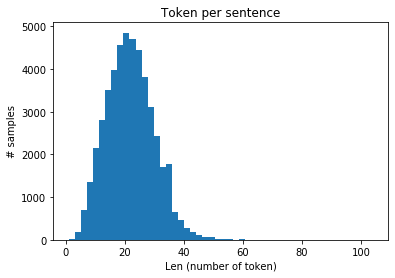

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [13]:
# ! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# After hyperparams optimization
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 5  # Number of passes through entire dataset
MAX_LEN = 80  # Max length of review (in words)
EMBEDDING = 40  # Dimension of word embedding vector
data = pd.read_csv('ner_stanford_dataset.csv', encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
   
getter = SentenceGetter(data)
# Get all the sentences
sentences = getter.sentences

# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

print("What the dataset looks like: ")
# Show the first 10 rows
data.head(24)

**Algorithms and Frameworks**

Our research included multiple machine learning classifiers including CRF and RNNs combined with CRF. 
We will employ deep learning methods from Tensorflow, Keras, spaCy along with traditional machine learning algorithms from scikit-learn and sklearn-crfsuite for entities recognition in the products attributes extraction context.


**Proof Of Concept**

We want to show two approaches to solve our problem:
  1. Conditional random fields (CRF) - a class of discriminative models suited to prediction tasks such as ours, where contextual information or state of the neighbors affect the current prediction. 
  2. Bi-directional LSTM-CRF model - a neural network that benefits from word and character level information and dependencies across adjacent labels which is also useful for textual data.  

**Conditional random fields (CRF):**

In this example we show a usage of CRF classifier on the person-organization-location dataset.
We first preprocess our data by assigning features to each of the tokens of the sentences and provide the information in that form to the CRF model

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('conll2002') # dataset

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]    

!pip install sklearn_crfsuite
# employ crf model
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
def crf_pipeline(X_train, y_train, X_test, y_test):
  crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=200, all_possible_transitions=True)
  crf.fit(X_train, y_train)
  labels = list(crf.classes_)
  y_pred = crf.predict(X_test)
  print(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels))
  print(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))

crf_pipeline(X_train, y_train, X_test, y_test)  



We can see that the scores are reasonable, although we may change our  algorithms if we will discover it is not suitable for the nature of our problem. 








**Bi-directional LSTM-CRF model**

In this approach, we use words embeddings made from the textual data and feed it to a neural net with bidirectional Conditional Random Field layer.

---



In [ ]:

######## preprocessing ##########
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"] = 0 # Padding
word2idx["UNK"] = 1 # Unknown words
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: t for t, i in tag2idx.items()}

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

########### Bidirectional-LSTM-CRF model ############

! pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

# Model training 
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)

# Evalualtion
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

!pip install sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

Even though the Bi-LSTM-CRF results on the CoNLL 2003 are dubious, according to the literature the scores are usually higher and we will understand how to achieve better results going forward.

**Reporting**

In our task we want to consider the F1 score while giving emphasis on precision.
We want to build our data set from an exisiting production eCommerce database. Currently we have tagged products data with several attributes and need to translate it to the needed format (token, POS, attribute label). After that we want to experiment with the mentioned and other models in an attempt to reach the highest possible scores. 

We would like to achieve a model in which the classifying labeling will run automatically preferably without expert human tagging.




**Summary**

Eventually we want to build and present the training, test and validation datasets that will consist of real online products unstructured data (i.e. description, names and specifications).

Out of the presented algoritms, for a similar task to ours, CRF currently seems to be able to achieve best results in terms of recall and precision. But nethertheless we want to adjust Bi-LSTM-CRF to our datasets and try to explore and combine other advanced techniques to improve quality of attributes labeling in terms of suitable conventional scoring metrics.



In [ ]:
import os
os.getcwd()